<a href="https://colab.research.google.com/github/claudio-bon/student-death-dignosis-bayesian-network/blob/main/student_death_dignosis_bayesian_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project
Author: Claudio Bonetta

Following is the graphical representation of the Bayesian Network that will be used for this project:<br>
![](https://drive.google.com/uc?export=view&id=1KxTcI-FddBTJhpijdZtpvAWmqbQnO8mA)

# Bayesian Network's Definition

In [1]:
!pip install pgmpy==0.1.10

     |████████████████████████████████| 339 kB 5.0 MB/s 


Now it will be defined the network's structure (which is shaped as a directed graph).

In [2]:
from pgmpy.models import BayesianModel

model = BayesianModel([
    ('Break Up', 'Emotional Shock'),
    ('Relative Lost', 'Emotional Shock'),
    ('Emotional Shock', 'Depression'),
    ('No Friends & Family', 'Depression'),
    ('Financial Problem', 'Chronic Stress'),
    ('Work/Study Pressure', 'Chronic Stress'),
    ('Chronic Stress', 'Insomnia'),
    ('Serious Ilness', 'Prior Stroke'),
    ('Depression', 'Suicide'),
    ('Chronic Stress', 'Suicide'),
    ('Prior Stroke', 'Suicide')])

Through the library <code>networkx</code> it's checked the correctness of the above definition of the Bayesian Network.

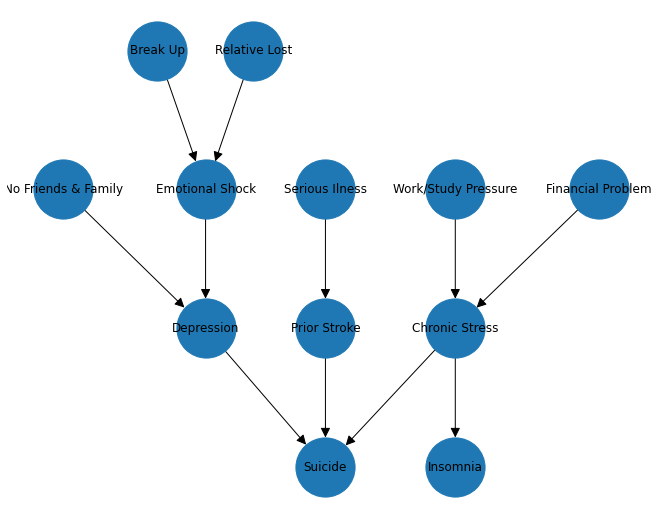

In [3]:
import matplotlib.pyplot as plt
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

plt.figure(figsize=(9,7))
pos = graphviz_layout(model, prog="dot")
nx.draw(model, pos, with_labels=True, arrowsize=20, node_size=3500, font_color='k', font_size=12)
plt.show()

Below are defined the **Conditional Probability Distribution** tables (**CPD** tables).

In [4]:
from pgmpy.factors.discrete import TabularCPD


cpd_bu = TabularCPD(variable='Break Up', variable_card=2,
                        values=[[0.8], [0.2]])

cpd_rl = TabularCPD(variable='Relative Lost', variable_card=2,
                        values=[[0.9], [0.1]])

cpd_es = TabularCPD(variable='Emotional Shock', variable_card=2,
                        values=[[0.95, 0.4, 0.6, 0.15],
                                [0.05, 0.6, 0.4, 0.85]],
                        evidence=['Break Up', 'Relative Lost'],
                        evidence_card=[2, 2])

cpd_nff = TabularCPD(variable='No Friends & Family', variable_card=2,
                        values=[[0.5], [0.5]])

cpd_dep = TabularCPD(variable='Depression', variable_card=2,
                        values=[[0.9, 0.2, 0.25, 0.02],
                                [0.1, 0.8, 0.75, 0.98]],
                        evidence=['Emotional Shock', 'No Friends & Family'],
                        evidence_card=[2, 2])

cpd_fnp = TabularCPD(variable='Financial Problem', variable_card=2,
                        values=[[0.7], [0.3]])

cpd_wsp = TabularCPD(variable='Work/Study Pressure', variable_card=2,
                        values=[[0.7], [0.3]])

cpd_cst = TabularCPD(variable='Chronic Stress', variable_card=2,
                        values=[[0.9, 0.4, 0.2, 0.05],
                                [0.1, 0.6, 0.8, 0.95]],
                        evidence=['Financial Problem', 'Work/Study Pressure'],
                        evidence_card=[2, 2])

cpd_ins = TabularCPD(variable='Insomnia', variable_card=2,
                      values=[[0.97, 0.05], [0.03, 0.95]],
                      evidence=['Chronic Stress'], evidence_card=[2])

cpd_sil = TabularCPD(variable='Serious Ilness', variable_card=2,
                        values=[[0.8], [0.2]])

cpd_ps = TabularCPD(variable='Prior Stroke', variable_card=2,
                      values=[[0.8, 0.05], [0.2, 0.95]],
                      evidence=['Serious Ilness'], evidence_card=[2])

cpd_su = TabularCPD(variable='Suicide', variable_card=2,
                        values=[[0.95, 0.98, 0.6, 0.7, 0.25, 0.35, 0.05, 0.2],
                                [0.05, 0.02, 0.4, 0.3, 0.75, 0.65, 0.95, 0.8]],
                        evidence=['Depression', 'Chronic Stress', 'Prior Stroke'],
                        evidence_card=[2, 2, 2])

Add the CDPs to the model.

In [5]:
model.add_cpds(cpd_bu, cpd_rl, cpd_es, cpd_nff, cpd_dep, cpd_fnp, cpd_wsp, cpd_cst, cpd_ins, cpd_sil, cpd_ps, cpd_su)

In order to assert that the above definition of the Bayesian Network is correctly given, it's possible to peform a check.

In [6]:
model.check_model()

True

pgmpy allow also to print out CDPs.<br>
Let's do so in order to check the correct definition of a CDP.

In [7]:
print(model.get_cpds('Depression'))

+---------------------+------------------------+------------------------+------------------------+------------------------+
| Emotional Shock     | Emotional Shock(0)     | Emotional Shock(0)     | Emotional Shock(1)     | Emotional Shock(1)     |
+---------------------+------------------------+------------------------+------------------------+------------------------+
| No Friends & Family | No Friends & Family(0) | No Friends & Family(1) | No Friends & Family(0) | No Friends & Family(1) |
+---------------------+------------------------+------------------------+------------------------+------------------------+
| Depression(0)       | 0.9                    | 0.2                    | 0.25                   | 0.02                   |
+---------------------+------------------------+------------------------+------------------------+------------------------+
| Depression(1)       | 0.1                    | 0.8                    | 0.75                   | 0.98                   |
+-------

# Full Joint Distribution

In the following section it will be defined the function that computes the full joint distribution of the BN.<br>
The function defined below follows the definition:<br>
$ P(x_1,..., x_n) = \prod \limits _{i=1} ^{n} P(x_i|parents(X_i))$

In [8]:
def full_joint_distr(model, rvs):
    cpds = model.get_cpds()
    
    for cpd in cpds:
        if cpd.variable not in rvs:
            raise ValueError()
        if not isinstance(rvs[cpd.variable], int):
            raise ValueError()
            
    FJD = 1
    for cpd in cpds:
        val = cpd.values
        for variable in cpd.variables:
            val = val[rvs[variable]]
        FJD *= val
    return FJD

In [9]:
full_joint_distr(model, {'Break Up':1,
                         'Relative Lost':1,
                         'Emotional Shock':1,
                         'No Friends & Family':1,
                         'Depression':1,
                         'Financial Problem':1,
                         'Work/Study Pressure':1,
                         'Chronic Stress':1,
                         'Insomnia':1,
                         'Serious Ilness':0,
                         'Prior Stroke':0,
                         'Suicide':1,
                        })

0.00041137538399999994

The previous result is verifiable in the following way:<br>

$
P(x_1,..., x_n) = \prod \limits _{i=1} ^{n} P(x_i|parents(X_i)) = \\
P(Suicide=1\ |\ Depression=1,\ Chronic\ Stress=1,\ Prior\ Stroke=0) \\ \cdot
P(Depression=1\ |\ Emotional\ Shock=1,\ No\ Friends\ \&\ Family=1)\cdot
P(No\ Friends\ \&\ Family=1)\cdot
P(Emotional\ Shock=1\ |\ Break\ Up=1,\ Relative\ Lost=1)\cdot
P(Break\ Up=1)\cdot
P(Relative\ Lost=1)\cdot
P(Insomnia=1\ |\ Chronic\ Stress=1)\cdot
P(Chronic\ Stress=1\ |\ Financial\ Problem=1,\ Work/Study\ Pressure=1)\cdot
P(Financial\ Problem=1)\cdot
P(Work/Study\ Pressure=1)\cdot
P(Prior\ Stroke=0\ |\ Serious\ Illness=0)\cdot
P(Serious\ Illness=0)\ = \\
0.95\cdot
0.98\cdot
0.5\cdot
0.95\cdot
0.85\cdot
0.2\cdot
0.1\cdot
0.95\cdot
0.3\cdot
0.3\cdot
0.8\cdot
0.8 = \\
0.000411375384
$
<br>
<br>And indeed the results are equivalent.

# Active Trail

The following queries will show the presence of active trails between two nodes of the BN.

First it is shown the presence of an active trail.

In [10]:
cdp_act1 = 'Insomnia'
cdp_act2 = 'Financial Problem'

answer = {True:'Yes', False:'No'}
print('Is there an active trail between {} and {}?\n{}'.format(cdp_act1,
                                                               cdp_act2,
                                                               answer[model.is_active_trail(cdp_act1, cdp_act2)]))

Is there an active trail between Insomnia and Financial Problem?
Yes


And the result on the BN itself:<br>
![](https://drive.google.com/uc?export=view&id=10hoJMIs3dBxdgGIkTZUmiqW0L-X99HR8)

In particular the link connecting Insomnia and Financial Problem can be said to be an evidential trail.

And then as a second example two nodes not having an active trail.

In [11]:
cdp_nact1 = 'Insomnia'
cdp_nact2 = 'Emotional Shock'

answer = {True:'Yes', False:'No'}
print('Is there an active trail between {} and {}?\n{}'.format(cdp_nact1,
                                                               cdp_nact2,
                                                               answer[model.is_active_trail(cdp_nact1, cdp_nact2)]))

Is there an active trail between Insomnia and Emotional Shock?
No


The absence of an active trail can be clearly seen by the graphical representation of the BN:<br>
![](https://drive.google.com/uc?export=view&id=1cv-JF0xghPVZoyQ30WhMAdt27ZtLp6mH)

Since we are in presence of a V-structure (common evidence) in order to have an active trail between Insomnia and Emotional Shock the R.V. Suicide has to be taken as observed.

In [12]:
observed_var = 'Suicide'

print('Given Suicide is there an active trail between Insomnia and Emotional Shock?')
answer = {True:'Yes', False:'No'}
print(answer['Insomnia' in model.active_trail_nodes('Emotional Shock', observed=observed_var)['Emotional Shock']])

Given Suicide is there an active trail between Insomnia and Emotional Shock?
Yes


# Local Indipendence
The concept of local independence is tightly related to the concept of active trail.<br>
In particular two nodes can be said to be independent iff there's no active trail between the two nodes given a set of observed nodes.

To get a single independence for a given node it can be run the following query:

In [13]:
model.local_independencies('Depression')

(Depression _|_ Relative Lost, Financial Problem, Break Up, Serious Ilness, Work/Study Pressure, Insomnia, Prior Stroke, Chronic Stress | No Friends & Family, Emotional Shock)

To get all independecies for all the nodes it can be run the following query:

In [ ]:
model.get_independencies()

To get all the independencies of a node it can be done:

In [ ]:
from pgmpy.independencies.Independencies import Independencies

ind_node = 'Depression'
Independencies(*[ind for ind in model.get_independencies().get_assertions()
                 if list(ind.event1)[0]==ind_node])

# Markov Blanket
To define a Markov Blanket for a given node it's needed to take as observed its parents, children and its children's parents.

As such to find a Markov Blanket for the node Depression we can do the following:

In [16]:
def get_markov_blanket(node):
    parents = model.get_parents(node=node)
    children = model.get_children(node=node)
    children_parents = []
    for child in children:
        children_parents = children_parents + model.get_parents(node=child)
        
    markov_b = set(parents + children + children_parents) - {node}
    return list(markov_b)

In [17]:
node_mrk = 'Depression'
print('The Markov Blanket for {} is:\n{}'.format(node_mrk, get_markov_blanket(node_mrk)))

The Markov Blanket for Depression is:
['Emotional Shock', 'Suicide', 'No Friends & Family', 'Prior Stroke', 'Chronic Stress']


pgmpy already has a function to get the Markov blanket given a node:

In [18]:
print('The Markov Blanket for {} is:\n{}'.format(node_mrk, model.get_markov_blanket(node_mrk)))

The Markov Blanket for Depression is:
['Emotional Shock', 'Suicide', 'No Friends & Family', 'Prior Stroke', 'Chronic Stress']


It can be observed that the two above definitions are coherent.

Following it can be seen the graphical representation of the Markov Blanket defined above:<br>
![](https://drive.google.com/uc?export=view&id=12S0LjtkgnUuoSZwXd2IQ-fJ75xr-E4gT)

It can be shown that, given the Markov Blanket of a node, it achieves local indepencence with respect to all of the other nodes of the network.

In [19]:
model.active_trail_nodes(node_mrk, observed=model.get_markov_blanket(node_mrk))[node_mrk] - {node_mrk}

set()

# Exact Inference
In this section are present some inference queries using the variable elimination method.

In [20]:
from pgmpy.inference import VariableElimination
infer = VariableElimination(model)

In the following it's going to be inferred:<br>
$ P(Suicice\ |\ Emotional\ Shock=1,\ Work/Study\ Pressure=1,\ Financial\ Problem=0) $

In [21]:
query = infer.query(variables=['Suicide'],
                evidence={'Emotional Shock': 1, 'Work/Study Pressure':1, 'Financial Problem':0})
print(query)

Eliminating: Chronic Stress: 100%|██████████| 8/8 [00:00<00:00, 260.52it/s]

+------------+----------------+
| Suicide    |   phi(Suicide) |
+============+================+
| Suicide(0) |         0.2551 |
+------------+----------------+
| Suicide(1) |         0.7449 |
+------------+----------------+


$
P(SU\ |\ es,\ wsp,\ \neg fnp)\ = \\
\alpha\ \sum _{dep} \sum _{nff} \sum _{bu} \sum _{rl} \sum _{cst} \sum _{ins} \sum _{ps} \sum _{sil}
P(SU\ |\ dep,\ cst,\ ps)\cdot
P(dep\ |\ es,\ nff)\cdot
P(es\ |\ bu,\ rl)\cdot
P(bu)\cdot
P(rl)\cdot
P(ins\ |\ cst)\cdot
P(cst\ |\ \neg fnp,\ wsp)\cdot
P(\neg fnp)\cdot
P(wsp)\cdot
P(ps\ |\ sil)\cdot
P(sil)
$
<br><br>
Then an ordering of the hidden variables has to be chosen (pgmpy by default uses an heuristic called Min-Fill) and the process of variable elimination is carried out.<br>
Other considerations can be done about the presence of irrelevant variables, where an irrelevant variable for $ P(X\ |\ E) $ is $ Y \notin Ancenstors(\{ X\} \cup E) $ or if $Y$ is d-separated from $X$ by $E$.<br>
Thus the following variables can be deemed to be irrelevant: **Break Up** and **Relative Lost** since they are d-separated from Suicide by Emotional Shock and **Insomnia** since it does not belong to the ancestral graph of neither Suicide nor of the given evidences.<br>
Lastly it can be worth to notice that, being this Bayesian Network a polytree (there's only one path connecting every pair of nodes of the network), the process of exact inference should be fairly efficient.

To effectively verify that the defined BN is a polytree it can be done the following:

In [22]:
from networkx.algorithms.tree.recognition import is_tree
is_tree(model)

True

The following query will be on a joint probability distribution:<br>
$ P(Suicide,\ Depression\ |\ Relative\ Lost=1,\ Break\ Up=0,\ Chronic\ Stress=1) $

In [23]:
query = infer.query(variables=['Suicide','Depression'],
                evidence={'Relative Lost':1, 'Break Up':0, 'Chronic Stress':1})
print(query)

Eliminating: Serious Ilness: 100%|██████████| 7/7 [00:00<00:00, 273.47it/s]

+------------+---------------+---------------------------+
| Suicide    | Depression    |   phi(Suicide,Depression) |
+============+===============+===========================+
| Suicide(0) | Depression(0) |                    0.1911 |
+------------+---------------+---------------------------+
| Suicide(0) | Depression(1) |                    0.0716 |
+------------+---------------+---------------------------+
| Suicide(1) | Depression(0) |                    0.1099 |
+------------+---------------+---------------------------+
| Suicide(1) | Depression(1) |                    0.6274 |
+------------+---------------+---------------------------+
